In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import os
from sklearn.manifold import TSNE
import sklearn.decomposition
import seaborn as sns

from jqdatasdk import *
auth('17780620786','xxb19880825')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

auth success


In [2]:
def check_for_nulls(df,show=True):
    """
    Test and report number of NAs in each column of the input data frame
    :param df: pandas.DataFrame
    :return: None
    """
    null_dict = {}
    for col in df.columns.values:
        num_nans = np.sum(df[col].isnull())
        if num_nans > 0 and show:
            print('%d Nans in col %s' % (num_nans, col))
        null_dict[col] = num_nans
    print('New shape of df: ', df.shape)
    return null_dict

In [3]:
start_date = '2005-08-01'
end_date = '2017-12-31'
market_symbol = '000300.XSHG'
# get stock price
price_df = pd.read_csv('data/price.csv',parse_dates=[0],dtype={'paused':np.bool})
price_df = price_df[price_df.date>start_date]
# get index price
index_df = get_price([market_symbol],start_date=start_date, end_date=end_date)['close']
# get index elements
HF300_stocks = get_index_stocks(market_symbol)
HF300_price_df = price_df[price_df.symbol.isin(HF300_stocks)]


In [361]:
# check NAs in HF300
null_dict = check_for_nulls(HF300_price_df.pivot(index='date',columns='symbol',values='close'),True)

145 Nans in col 000001.XSHE
197 Nans in col 000002.XSHE
75 Nans in col 000060.XSHE
95 Nans in col 000063.XSHE
122 Nans in col 000069.XSHE
345 Nans in col 000100.XSHE
126 Nans in col 000157.XSHE
2334 Nans in col 000166.XSHE
1998 Nans in col 000333.XSHE
484 Nans in col 000338.XSHE
54 Nans in col 000402.XSHE
246 Nans in col 000413.XSHE
597 Nans in col 000415.XSHE
150 Nans in col 000423.XSHE
115 Nans in col 000425.XSHE
276 Nans in col 000503.XSHE
166 Nans in col 000538.XSHE
290 Nans in col 000540.XSHE
53 Nans in col 000559.XSHE
104 Nans in col 000568.XSHE
103 Nans in col 000623.XSHE
225 Nans in col 000625.XSHE
169 Nans in col 000627.XSHE
213 Nans in col 000630.XSHE
195 Nans in col 000651.XSHE
283 Nans in col 000671.XSHE
203 Nans in col 000709.XSHE
474 Nans in col 000723.XSHE
105 Nans in col 000725.XSHE
300 Nans in col 000728.XSHE
158 Nans in col 000768.XSHE
918 Nans in col 000776.XSHE
293 Nans in col 000783.XSHE
190 Nans in col 000786.XSHE
270 Nans in col 000792.XSHE
119 Nans in col 000826

In [362]:
stock_tickers = [symbol for symbol,nulls in null_dict.items() if nulls < 200]
len(stock_tickers)

103

In [363]:
asset_prices = price_df[price_df.symbol.isin(stock_tickers)]\
                    .pivot(index='date',columns='symbol',values='close')
asset_prices[market_symbol] = index_df[market_symbol]

In [364]:
asset_prices.head()

symbol,000001.XSHE,000002.XSHE,000060.XSHE,000063.XSHE,000069.XSHE,000157.XSHE,000402.XSHE,000423.XSHE,000425.XSHE,000538.XSHE,...,600741.XSHG,600795.XSHG,600804.XSHG,600809.XSHG,600820.XSHG,600837.XSHG,600867.XSHG,600886.XSHG,600887.XSHG,000300.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2005-08-02,1.40,1.23,0.65,4.69,1.33,0.35,1.85,4.19,0.25,4.33,...,0.89,0.99,0.44,2.31,0.89,1.51,0.38,NaN,1.15,903.598
2005-08-03,1.41,1.27,0.65,4.73,1.37,0.36,1.90,4.15,0.28,4.30,...,0.90,1.00,0.44,2.29,0.90,1.53,0.39,NaN,1.15,909.570
2005-08-04,1.40,1.28,0.64,4.55,1.36,0.36,1.86,4.16,0.27,4.25,...,0.89,1.00,0.43,2.25,0.89,1.52,0.38,NaN,1.15,904.150
2005-08-05,1.44,1.31,0.65,4.58,1.40,0.37,1.89,4.21,0.27,4.33,...,0.89,1.02,0.45,2.36,0.92,1.60,0.39,NaN,1.12,923.803
2005-08-08,1.45,1.30,0.66,4.54,1.40,0.37,1.83,4.15,0.28,4.19,...,0.90,1.00,0.46,2.35,0.93,1.68,0.40,NaN,1.11,927.471


\begin{align*}
R_{ik} &= \frac{S_{i(t_0-(k-1)\Delta t)}-S_{i(t_0-k \Delta t)}}{S_{i(t_0-k \Delta t)}}\\
Y_{ik} &= \frac{R_{ik}-\bar{R_i}}{\bar{\sigma_i}}\\
\bar{R_i} &= \frac{1}{M} \sum_{k=1}^{M}R_{ik}\\
\bar{\sigma_i}^2 &= \frac{1}{M-1} \sum_{k=1}^{M}(R_{ik}-\bar{R_i})^2
\end{align*}

In [391]:
train_start = datetime.datetime(2006,1,1)
train_end = datetime.datetime(2016, 1, 1) 
asset_returns = (asset_prices/asset_prices.shift(1)-1).dropna(how='all')#(np.log(asset_prices)-np.log(asset_prices.shift(1))).dropna(how='all')
M = 90
# 计算滚动均值时，向后补全
rolling_mean_returns = asset_returns.rolling(M,min_periods=M//2).mean().dropna(how='all').ffill()#.fillna(method='ffill').rolling(M).mean().dropna(how='all')
# 计算滚动标准差时，窗口计算（设置最小计算窗口为滑动窗口的一半），空值向上补全
rolling_std_returns = asset_returns.rolling(M,min_periods=M//2).std().dropna(how='all').ffill()
# 06年开始，排除预留数据
asset_returns = asset_returns[asset_returns.index >= train_start]
rolling_mean_returns = rolling_mean_returns[rolling_mean_returns.index >= train_start]
rolling_std_returns = rolling_std_returns[rolling_std_returns.index >= train_start]
# 对为NA的return补全为0，假设没有波动
normed_returns = (asset_returns.fillna(0.0)-rolling_mean_returns)/rolling_std_returns



#asset_returns = asset_prices.pct_change().dropna()
#normed_returns = (asset_returns-asset_returns.mean())/asset_returns.std()


In [392]:
null_dict = check_for_nulls(normed_returns,True)

New shape of df:  (2917, 104)


In [125]:
#HF300_price_df[HF300_price_df.symbol == '600050.XSHG'].set_index('date').loc['2017-03-01':] 

In [86]:
# NA cases
#asset_returns.loc['2017-08-11':'2017-08-18','600050.XSHG'] 
#rolling_mean_returns.loc['2017-08-01':'2017-08-18','600050.XSHG']
#rolling_std_returns.loc['2017-08-01':'2017-08-18','600050.XSHG']

In [393]:
df_train = normed_returns[normed_returns.index < train_end].copy()
df_test = normed_returns[normed_returns.index >= train_end].copy()

filled_asset_returns = asset_returns.fillna(0.0)
df_raw_train = filled_asset_returns[filled_asset_returns.index < train_end].copy()
df_raw_test = filled_asset_returns[filled_asset_returns.index >= train_end].copy()

print('Train dataset:', df_train.shape)
print('Test dataset:', df_test.shape)

Train dataset: (2429, 104)
Test dataset: (488, 104)


In [394]:
n_tickers = len(stock_tickers)
pca = None
cov_matrix = pd.DataFrame(data=np.ones(shape=(n_tickers, n_tickers)), columns=stock_tickers)
cov_matrix_raw = cov_matrix

if df_train is not None and df_raw_train is not None:
    stock_tickers = asset_returns.columns.values[:-1]

    cov_matrix = df_train[stock_tickers].cov()
    cov_matrix_raw = df_raw_train[stock_tickers].cov()
    pca = sklearn.decomposition.PCA()
    pca.fit(cov_matrix)
    
    if pca is not None:
        cov_raw_df = pd.DataFrame({'Variance': np.diag(cov_matrix_raw)}, index=stock_tickers)    
        # cumulative variance explained
        var_threshold = 0.8
        var_explained = np.cumsum(pca.explained_variance_ratio_)
        num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1  # +1 due to zero based-arrays
        print('%d components explain %.2f%% of variance' %(num_comp, 100* var_threshold))
    

20 components explain 80.00% of variance


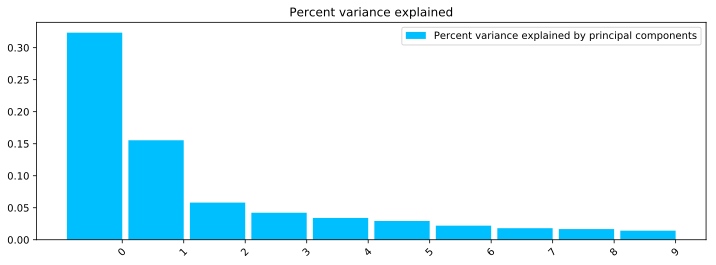

In [395]:
if pca is not None:
    bar_width = 0.9
    n_asset = int((1 / 10) * normed_returns.shape[1])
    x_indx = np.arange(n_asset)
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    # Eigenvalues are measured as percentage of explained variance.
    rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], bar_width, color='deepskyblue')
    ax.set_xticks(x_indx + bar_width / 2)
    ax.set_xticklabels(list(range(n_asset)), rotation=45)
    ax.set_title('Percent variance explained')
    ax.legend((rects[0],), ('Percent variance explained by principal components',))

Sum of weights of first eigen-portfolio: 100.00


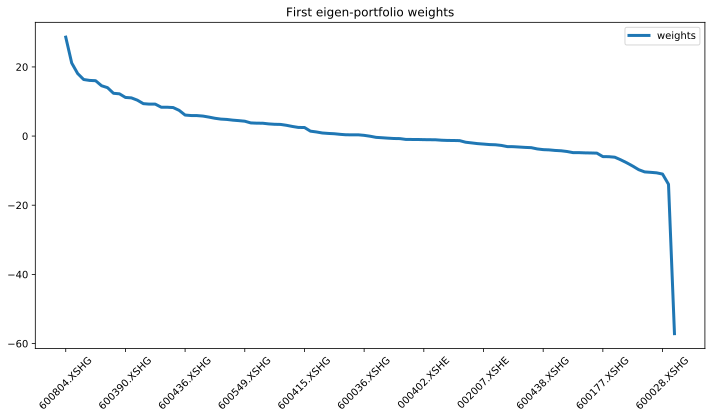

In [396]:
if pca is not None:
    projected = pca.fit_transform(cov_matrix)
# the first two eigen-portfolio weights
# first component
# get the Principal components
pc_w = np.zeros(len(stock_tickers))
eigen_prtf1 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
if pca is not None:
    pcs = pca.components_

    pc_w = pcs[:,0]/pcs[:,0].sum()

    eigen_prtf1 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
    eigen_prtf1.sort_values(by=['weights'], ascending=False, inplace=True)
    print('Sum of weights of first eigen-portfolio: %.2f' % np.sum(eigen_prtf1))
    eigen_prtf1.plot(title='First eigen-portfolio weights', 
                     figsize=(12,6), 
                     xticks=range(0, len(stock_tickers),10), 
                     rot=45, 
                     linewidth=3)

In [350]:
pcs[:,0]/pcs[:,0].sum()

array([-0.26791036, -0.21997559, -0.01131965,  0.14401552,  0.12403672,
        0.05925263,  0.14854818, -0.11919834,  0.13107678,  0.10130131,
        0.74707718,  0.16309563])

Sum of weights of second eigen-portfolio: 100.00


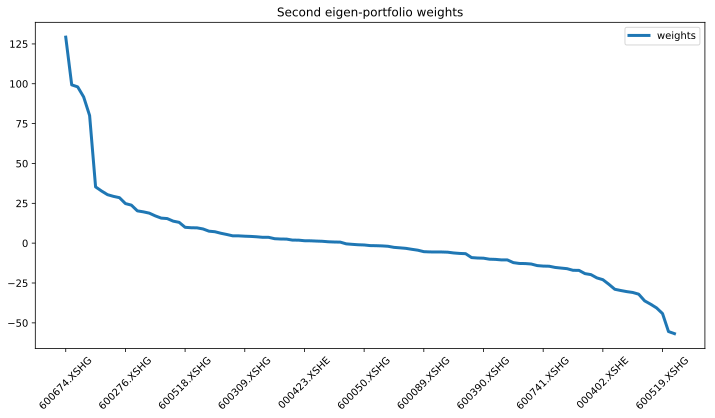

In [397]:
pc_w = np.zeros(len(stock_tickers))
eigen_prtf2 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)

if pca is not None:
    pcs = pca.components_
    
    ### START CODE HERE ### (≈ 1-2 lines of code)
    pc_w = pcs[:,1]/pcs[:,1].sum()
    
    ### END CODE HERE ###

    eigen_prtf2 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
    eigen_prtf2.sort_values(by=['weights'], ascending=False, inplace=True)
    print('Sum of weights of second eigen-portfolio: %.2f' % np.sum(eigen_prtf2))
    eigen_prtf2.plot(title='Second eigen-portfolio weights',
                     figsize=(12,6), 
                     xticks=range(0, len(stock_tickers),10), 
                     rot=45, 
                     linewidth=3)

In [398]:
def sharpe_ratio(ts_returns, periods_per_year=252):
    """
    sharpe_ratio - Calculates annualized return, annualized vol, and annualized sharpe ratio, 
                    where sharpe ratio is defined as annualized return divided by annualized volatility 
                    
    Arguments:
    ts_returns - pd.Series of returns of a single eigen portfolio
    
    Return:
    a tuple of three doubles: annualized return, volatility, and sharpe ratio
    """
    annualized_return = ts_returns.mean()*periods_per_year
    annualized_vol  = ts_returns.std()*np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return/annualized_vol
    
    return annualized_return, annualized_vol, annualized_sharpe

First eigen-portfolio:
Return = 26.22%
Volatility = 46.76%
Sharpe = 0.56


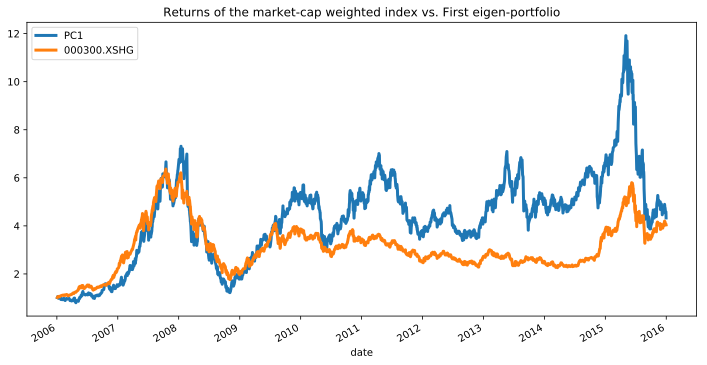

In [399]:
if df_raw_train is not None:
    eigen_prtf1_returns = np.dot(df_raw_train.loc[:, eigen_prtf1.index], eigen_prtf1 / 100)
    eigen_prtf1_returns = pd.Series(eigen_prtf1_returns.squeeze(), index=df_train.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf1_returns)
    print('First eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))
    year_frac = (eigen_prtf1_returns.index[-1] - eigen_prtf1_returns.index[0]).days / 252

    df_plot = pd.DataFrame({'PC1': eigen_prtf1_returns, market_symbol: df_raw_train.loc[:, market_symbol]}, index=df_train.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First eigen-portfolio', 
                             figsize=(12,6), linewidth=3)

First eigen-portfolio:
Return = 44.62%
Volatility = 37.54%
Sharpe = 1.19


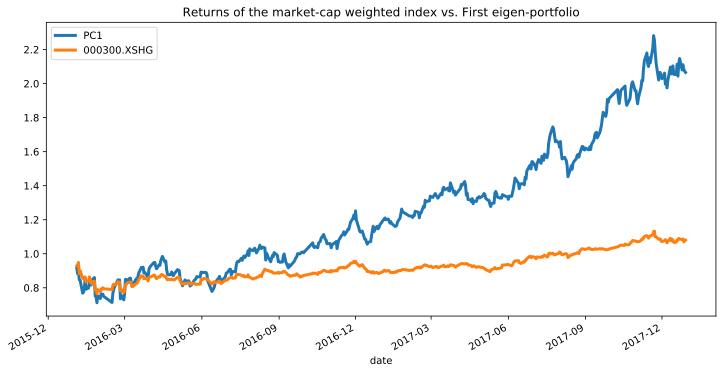

In [400]:
if df_raw_test is not None:
    eigen_prtf1_returns = np.dot(df_raw_test.loc[:, eigen_prtf1.index], eigen_prtf1 / 100)
    eigen_prtf1_returns = pd.Series(eigen_prtf1_returns.squeeze(), index=df_test.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf1_returns)
    print('First eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))
    year_frac = (eigen_prtf1_returns.index[-1] - eigen_prtf1_returns.index[0]).days / 252

    df_plot = pd.DataFrame({'PC1': eigen_prtf1_returns, market_symbol: df_raw_test.loc[:, market_symbol]}, index=df_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First eigen-portfolio', 
                             figsize=(12,6), linewidth=3)

In [401]:
if df_raw_test is not None:
    eigen_prtf2_returns = np.dot(df_raw_test.loc[:, eigen_prtf2.index], eigen_prtf2 / 100)
    eigen_prtf2_returns = pd.Series(eigen_prtf2_returns.squeeze(), index=df_test.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf2_returns)
    print('Second eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (er*100, vol*100, sharpe))

Second eigen-portfolio:
Return = -71.43%
Volatility = 61.14%
Sharpe = -1.17


Eigen portfolio #102 with the highest Sharpe. Return 44.62%, vol = 37.54%, Sharpe = 1.19


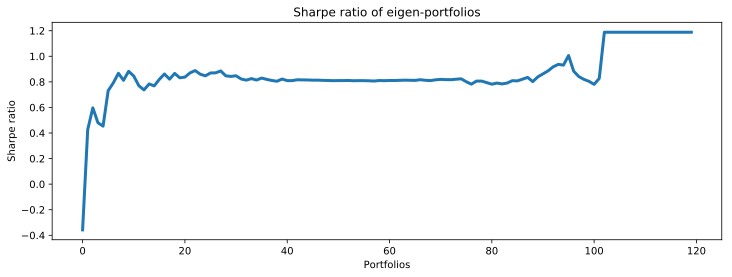

In [402]:
n_portfolios = 120
annualized_ret = np.array([0.] * n_portfolios)
sharpe_metric = np.array([0.] * n_portfolios)
annualized_vol = np.array([0.] * n_portfolios)
idx_highest_sharpe = 0 # index into sharpe_metric which identifies a portfolio with rhe highest Sharpe ratio
    
if pca is not None:
    for ix in range(n_portfolios):
        

        #eigen_prtf1 = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        #eigen_prtf1.sort_values(by=['weights'], ascending=False, inplace=True)
        eigen_prtf_returns = np.dot(df_raw_test.loc[:, eigen_prtf1.index[:(ix+1)]], eigen_prtf1[:(ix+1)] / 100)
        eigen_prtf_returns = pd.Series(eigen_prtf_returns.squeeze(), index=df_test.index)
        er, vol, sharpe = sharpe_ratio(eigen_prtf_returns)
        annualized_ret[ix] = er
        annualized_vol[ix] = vol
        sharpe_metric[ix] = er/vol

    
    # find portfolio with the highest Sharpe ratio

    idx_highest_sharpe = np.argmax(sharpe_metric)

    
    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (idx_highest_sharpe,
           annualized_ret[idx_highest_sharpe]*100, 
           annualized_vol[idx_highest_sharpe]*100, 
           sharpe_metric[idx_highest_sharpe]))

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

In [220]:
results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
results.head(10)

,Return,Vol,Sharpe
100,0.181615,0.269185,0.674684
96,0.201266,0.315525,0.637876
97,0.191496,0.302672,0.632685
95,0.205513,0.327965,0.626631
5,0.101959,0.164839,0.618535
92,0.213933,0.348026,0.614705
94,0.205999,0.335468,0.614065
93,0.209102,0.341748,0.611860
11,0.157962,0.258801,0.610362
109,0.135152,0.221503,0.610159


In [426]:
# pca on using 15 eigenportfolios
pc_w = np.zeros(len(stock_tickers))
num_eigenportfolios = 12
eigen_prtf = pd.DataFrame(data ={'weights_'+str(i): pc_w.squeeze()*100 for i in range(num_eigenportfolios)}, index = stock_tickers)


for i in range(num_eigenportfolios):
    if pca is not None:
        pcs = pca.components_
        pc_w = pcs[:,i]/pcs[:,i].sum()
        col = 'weights_'+str(i)
        eigen_prtf[col] = pc_w.squeeze()*100
        print('Sum of weights of %d eigen-portfolio: %.2f' % (i+1, np.sum(eigen_prtf[col])))

eigen_prtf_first_n = pd.DataFrame(eigen_prtf.sum(axis=1)/num_eigenportfolios,stock_tickers)

Sum of weights of 1 eigen-portfolio: 100.00
Sum of weights of 2 eigen-portfolio: 100.00
Sum of weights of 3 eigen-portfolio: 100.00
Sum of weights of 4 eigen-portfolio: 100.00
Sum of weights of 5 eigen-portfolio: 100.00
Sum of weights of 6 eigen-portfolio: 100.00
Sum of weights of 7 eigen-portfolio: 100.00
Sum of weights of 8 eigen-portfolio: 100.00
Sum of weights of 9 eigen-portfolio: 100.00
Sum of weights of 10 eigen-portfolio: 100.00
Sum of weights of 11 eigen-portfolio: 100.00
Sum of weights of 12 eigen-portfolio: 100.00


First 12 eigen-portfolio:
Return = 11.37%
Volatility = 303.51%
Sharpe = 0.04


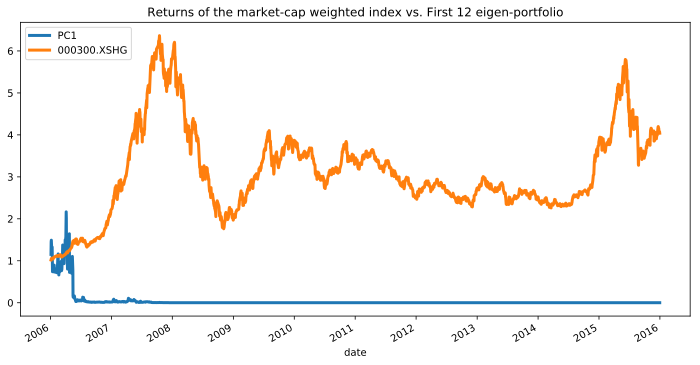

In [427]:
if df_raw_train is not None:
    eigen_prtf_first_n_returns = np.dot(df_raw_train.loc[:, eigen_prtf_first_n.index], eigen_prtf_first_n / 100)
    eigen_prtf_first_n_returns = pd.Series(eigen_prtf_first_n_returns.squeeze(), index=df_train.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf_first_n_returns)
    print('First %d eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (num_eigenportfolios,er*100, vol*100, sharpe))
    year_frac = (eigen_prtf_first_n_returns.index[-1] - eigen_prtf_first_n_returns.index[0]).days / 252

    df_plot = pd.DataFrame({'PC1': eigen_prtf_first_n_returns, market_symbol: df_raw_train.loc[:, market_symbol]}, index=df_train.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First %d eigen-portfolio' % num_eigenportfolios, 
                             figsize=(12,6), linewidth=3)

First 12 eigen-portfolio:
Return = -236.52%
Volatility = 225.94%
Sharpe = -1.05


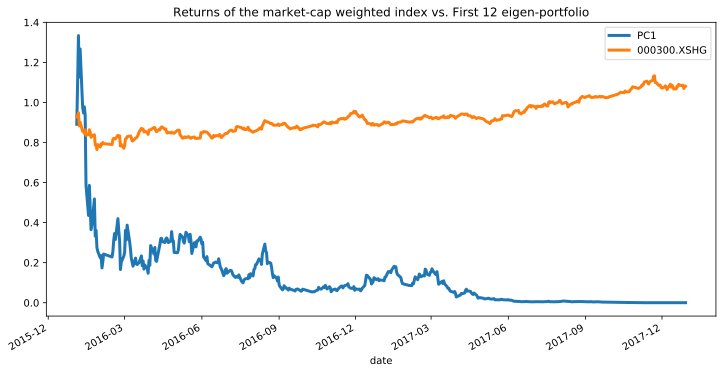

In [428]:
if df_raw_test is not None:
    eigen_prtf_first_n_returns = np.dot(df_raw_test.loc[:, eigen_prtf_first_n.index], eigen_prtf_first_n / 100)
    eigen_prtf_first_n_returns = pd.Series(eigen_prtf_first_n_returns.squeeze(), index=df_test.index)
    er, vol, sharpe = sharpe_ratio(eigen_prtf_first_n_returns)
    print('First %d eigen-portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (num_eigenportfolios,er*100, vol*100, sharpe))
    year_frac = (eigen_prtf_first_n_returns.index[-1] - eigen_prtf_first_n_returns.index[0]).days / 252

    df_plot = pd.DataFrame({'PC1': eigen_prtf_first_n_returns, market_symbol: df_raw_test.loc[:, market_symbol]}, index=df_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First %d eigen-portfolio' % num_eigenportfolios, 
                             figsize=(12,6), linewidth=3)